In [47]:
import pm4py
import pandas as pd
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns

## Data pre-processing

Event logs are already filtered and projected in ProM.
- event_log1 (A_events_new.xes) contains only A events with traces ending with A_Pending, A_Cancelled, A_Denied. This log is used for label extraction.
- event_log2 (OA_events.xes) contains A and O events. This log is used for prefix and feature extraction.

After processing, both logs are joined together to form the final set.

Open the event logs

In [2]:
event_log1 = pm4py.read_xes('data/A_events_new.xes')
event_log2 = pm4py.read_xes('data/OA_events.xes')

/Users/xuyou/opt/anaconda3/lib/python3.9/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/31411 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

Convert the event logs to dataframes

In [3]:
df1 = pm4py.convert_to_dataframe(event_log1)
df2 = pm4py.convert_to_dataframe(event_log2)

Nomalize the timestamps

In [6]:
df1['time:timestamp'] = pd.to_datetime(df1['time:timestamp'], utc=True)
df2['time:timestamp'] = pd.to_datetime(df2['time:timestamp'], utc=True)
df1['Year'] = df1['time:timestamp'].dt.year
df1['Month'] = df1['time:timestamp'].dt.month

## Add label

Based on the end activies
- If the trace ends with A_Pending "successful"
- If the trace ends with A_Cancelled or A_Denied, the label is "unsuccessful"

In [7]:
success_log = pm4py.filter_end_activities(event_log1, ["A_Pending"])
unsuccess_log = pm4py.filter_end_activities(event_log1, ["A_Cancelled", "A_Denied"])
df_suc = pm4py.convert_to_dataframe(success_log)
df_unsuc = pm4py.convert_to_dataframe(unsuccess_log)

df_suc['label'] = 'successful'
df_unsuc['label'] = 'unsuccessful'

# Concatenate the DataFrames
df1 = pd.concat([df_suc, df_unsuc], ignore_index=True)
df1.head()

/var/folders/v1/m2nqhx3d4yv9mjbpndrlsck00000gn/T/ipykernel_11616/2030576452.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_suc['label'] = 'successful'
/var/folders/v1/m2nqhx3d4yv9mjbpndrlsck00000gn/T/ipykernel_11616/2030576452.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unsuc['label'] = 'unsuccessful'


,Action,EventID,EventOrigin,org:resource,concept:name,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:RequestedAmount,case:concept:name,Year,Month,label
0,Created,Application_652823628,Application,User_1,A_Create Application,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,20000.0,Application_652823628,2016,1,successful
1,statechange,ApplState_1582051990,Application,User_1,A_Submitted,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,20000.0,Application_652823628,2016,1,successful
2,statechange,ApplState_642383566,Application,User_1,A_Concept,complete,2016-01-01 09:52:36.413000+00:00,Existing loan takeover,New credit,20000.0,Application_652823628,2016,1,successful
3,statechange,ApplState_99568828,Application,User_52,A_Accepted,complete,2016-01-02 11:23:04.299000+00:00,Existing loan takeover,New credit,20000.0,Application_652823628,2016,1,successful
4,statechange,ApplState_946455804,Application,User_52,A_Complete,complete,2016-01-02 11:30:28.633000+00:00,Existing loan takeover,New credit,20000.0,Application_652823628,2016,1,successful


## Prefix Encoding
We aim to predict the outcome of the application when the offer is sent. Therefore, all events before offer sent (included) are encoded as prefix.

In [8]:
# Show all unique events
unique_events = sorted(df2['concept:name'].unique())
unique_events

['A_Accepted',
 'A_Cancelled',
 'A_Complete',
 'A_Concept',
 'A_Create Application',
 'A_Denied',
 'A_Incomplete',
 'A_Pending',
 'A_Submitted',
 'A_Validating',
 'O_Accepted',
 'O_Cancelled',
 'O_Create Offer',
 'O_Created',
 'O_Refused',
 'O_Returned',
 'O_Sent (mail and online)',
 'O_Sent (online only)']

### Filter the event log to extract prefix

Filter the events so that only the events before O_Sent (mail and online) or O_Sent (online only) of each trace are kept

In [9]:
df2 = df2.sort_values(by=['case:concept:name', 'time:timestamp'])

def filter_rows(group):
    idx = group[group['concept:name'].isin(['O_Sent (mail and online)', 'O_Sent (online only)'])].index.min()
    if pd.notna(idx):
        return group.loc[:idx]
    return group

filtered_df2 = df2.groupby('case:concept:name', group_keys=False).apply(filter_rows)

### Encode the prefix by Aggreagation

In [10]:
result = pd.crosstab(filtered_df2['case:concept:name'], filtered_df2['concept:name']).reindex(unique_events, axis=1, fill_value=0)
result.head()

concept:name,A_Accepted,A_Cancelled,A_Complete,A_Concept,A_Create Application,A_Denied,A_Incomplete,A_Pending,A_Submitted,A_Validating,O_Accepted,O_Cancelled,O_Create Offer,O_Created,O_Refused,O_Returned,O_Sent (mail and online),O_Sent (online only)
case:concept:name,,,,,,,,,,,,,,,,,,
Application_1000086665,1,0,0,1,1,0,0,0,1,0,0,0,1,1,0,0,1,0
Application_1000158214,1,0,0,1,1,0,0,0,1,0,0,0,1,1,0,0,1,0
Application_1000311556,1,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,1,0
Application_1000334415,1,0,0,1,1,0,0,0,1,0,0,0,1,1,0,0,1,0
Application_1000339879,1,0,0,1,1,0,0,0,1,0,0,0,1,1,0,0,1,0


## Getting trace attribute and merge

Extract the case attributes

In [19]:
case_attr_df1 = df1.groupby('case:concept:name').agg({
    'case:LoanGoal': 'first',
    'case:RequestedAmount': 'first',
    'case:ApplicationType': 'first',
    'time:timestamp': 'first',
    'Month': 'first',
    'Year': 'first',
    'label': 'first'
}).reset_index()

case_attr_df2 = df2.groupby('case:concept:name').agg({
    'CreditScore': 'max'
}).reset_index()

case_attr = pd.merge(case_attr_df2, case_attr_df1, on='case:concept:name', how='inner')
case_attr.head()

,case:concept:name,CreditScore,case:LoanGoal,case:RequestedAmount,case:ApplicationType,time:timestamp,Month,Year,label
0,Application_1000086665,0.0,"Other, see explanation",5000.0,New credit,2016-08-03 15:57:21.673000+00:00,8,2016,unsuccessful
1,Application_1000158214,929.0,Home improvement,12500.0,New credit,2016-06-02 10:14:26.844000+00:00,6,2016,successful
2,Application_1000311556,0.0,Car,45000.0,New credit,2016-04-04 15:56:37.675000+00:00,4,2016,unsuccessful
3,Application_1000334415,0.0,"Other, see explanation",5000.0,New credit,2016-09-15 16:39:17.758000+00:00,9,2016,unsuccessful
4,Application_1000339879,798.0,Existing loan takeover,37500.0,New credit,2016-03-17 12:57:10.159000+00:00,3,2016,successful


Merge the trace attributes with the prefix encoding

In [20]:
merged_df = pd.merge(result, case_attr, on='case:concept:name', how='inner')
merged_df = merged_df.set_index('case:concept:name')
merged_df.head()

,A_Accepted,A_Cancelled,A_Complete,A_Concept,A_Create Application,A_Denied,A_Incomplete,A_Pending,A_Submitted,A_Validating,...,O_Sent (mail and online),O_Sent (online only),CreditScore,case:LoanGoal,case:RequestedAmount,case:ApplicationType,time:timestamp,Month,Year,label
case:concept:name,,,,,,,,,,,,,,,,,,,,,
Application_1000086665,1,0,0,1,1,0,0,0,1,0,...,1,0,0.0,"Other, see explanation",5000.0,New credit,2016-08-03 15:57:21.673000+00:00,8,2016,unsuccessful
Application_1000158214,1,0,0,1,1,0,0,0,1,0,...,1,0,929.0,Home improvement,12500.0,New credit,2016-06-02 10:14:26.844000+00:00,6,2016,successful
Application_1000311556,1,0,0,1,1,0,0,0,0,0,...,1,0,0.0,Car,45000.0,New credit,2016-04-04 15:56:37.675000+00:00,4,2016,unsuccessful
Application_1000334415,1,0,0,1,1,0,0,0,1,0,...,1,0,0.0,"Other, see explanation",5000.0,New credit,2016-09-15 16:39:17.758000+00:00,9,2016,unsuccessful
Application_1000339879,1,0,0,1,1,0,0,0,1,0,...,1,0,798.0,Existing loan takeover,37500.0,New credit,2016-03-17 12:57:10.159000+00:00,3,2016,successful


## Encode categorical features using one-hot encoding

In [21]:
one_hot_encoded_data = pd.get_dummies(merged_df['case:LoanGoal'], prefix='LoanGoal')
merged_df = merged_df.join(one_hot_encoded_data)
merged_df = merged_df.drop(columns=['case:LoanGoal'])

one_hot_encoded_data = pd.get_dummies(merged_df['case:ApplicationType'], prefix='ApplicationType')
merged_df = merged_df.join(one_hot_encoded_data)
merged_df = merged_df.drop(columns=['case:ApplicationType'])

merged_df.head()

,A_Accepted,A_Cancelled,A_Complete,A_Concept,A_Create Application,A_Denied,A_Incomplete,A_Pending,A_Submitted,A_Validating,...,LoanGoal_Extra spending limit,LoanGoal_Home improvement,LoanGoal_Motorcycle,LoanGoal_Not speficied,"LoanGoal_Other, see explanation",LoanGoal_Remaining debt home,LoanGoal_Tax payments,LoanGoal_Unknown,ApplicationType_Limit raise,ApplicationType_New credit
case:concept:name,,,,,,,,,,,,,,,,,,,,,
Application_1000086665,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
Application_1000158214,1,0,0,1,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
Application_1000311556,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Application_1000334415,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
Application_1000339879,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


## Train-validate-test set split

In [22]:
merged_df['time:timestamp'] = pd.to_datetime(merged_df['time:timestamp'])
merged_df.sort_values(by=['time:timestamp'], inplace=True)
merged_df.head()

,A_Accepted,A_Cancelled,A_Complete,A_Concept,A_Create Application,A_Denied,A_Incomplete,A_Pending,A_Submitted,A_Validating,...,LoanGoal_Extra spending limit,LoanGoal_Home improvement,LoanGoal_Motorcycle,LoanGoal_Not speficied,"LoanGoal_Other, see explanation",LoanGoal_Remaining debt home,LoanGoal_Tax payments,LoanGoal_Unknown,ApplicationType_Limit raise,ApplicationType_New credit
case:concept:name,,,,,,,,,,,,,,,,,,,,,
Application_652823628,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
Application_1691306052,1,0,0,1,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
Application_428409768,1,0,0,1,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
Application_1746793196,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
Application_828200680,1,0,0,1,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


Split the data into train and test set. Following time order, the first 70% of the traces are used for training, the next 10% for vallidation, and the last 20% for testing.

In [23]:
total_rows = len(merged_df)
train_size = int(0.7 * total_rows)
validation_size = int(0.1 * total_rows)
test_size = total_rows - train_size - validation_size

train = merged_df[:train_size]
validation = merged_df[train_size:train_size + validation_size]
test = merged_df[train_size + validation_size:]

Split

In [24]:
# Splitting the training set
X_train = train.drop('label', axis=1)
X_train = X_train.drop('time:timestamp', axis=1)
X_train = X_train.drop('Month', axis=1)
X_train = X_train.drop('Year', axis=1)
y_train = train['label']

# Splitting the validation set
X_validation = validation.drop('label', axis=1)
X_validation = X_validation.drop('time:timestamp', axis=1)
X_validation = X_validation.drop('Month', axis=1)
X_validation = X_validation.drop('Year', axis=1)
y_validation = validation['label']

# Splitting the testing set
X_test = test.drop('label', axis=1)
X_test = X_test.drop('time:timestamp', axis=1)
X_test = X_test.drop('Month', axis=1)
X_test = X_test.drop('Year', axis=1)
y_test = test['label']

In [25]:
X_train.head()

,A_Accepted,A_Cancelled,A_Complete,A_Concept,A_Create Application,A_Denied,A_Incomplete,A_Pending,A_Submitted,A_Validating,...,LoanGoal_Extra spending limit,LoanGoal_Home improvement,LoanGoal_Motorcycle,LoanGoal_Not speficied,"LoanGoal_Other, see explanation",LoanGoal_Remaining debt home,LoanGoal_Tax payments,LoanGoal_Unknown,ApplicationType_Limit raise,ApplicationType_New credit
case:concept:name,,,,,,,,,,,,,,,,,,,,,
Application_652823628,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
Application_1691306052,1,0,0,1,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
Application_428409768,1,0,0,1,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
Application_1746793196,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
Application_828200680,1,0,0,1,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


In [26]:
y_train.head()

case:concept:name
Application_652823628       successful
Application_1691306052    unsuccessful
Application_428409768       successful
Application_1746793196      successful
Application_828200680     unsuccessful
Name: label, dtype: object

In [27]:
y_test.head()

case:concept:name
Application_1046222107      successful
Application_1235896381    unsuccessful
Application_1985757094    unsuccessful
Application_396092392     unsuccessful
Application_585529210       successful
Name: label, dtype: object

# Create naive predictors
For the test set, randomly assign the two lables.

In [28]:
np.random.seed(0)

statuses = ['successful', 'unsuccessful']
y_test_naive = pd.Series(np.random.choice(statuses, size=len(y_test)), index=y_test.index)

print(y_test_naive[:10])

case:concept:name
Application_1046222107      successful
Application_1235896381    unsuccessful
Application_1985757094    unsuccessful
Application_396092392       successful
Application_585529210     unsuccessful
Application_1751900898    unsuccessful
Application_867435788     unsuccessful
Application_543098684     unsuccessful
Application_1090974006    unsuccessful
Application_2087713022    unsuccessful
dtype: object


## Prediction

### Naive Predictor Performance

In [46]:
accuracy_score(y_test_naive, y_test)

0.5091516791341716

### Decision Tree

In [41]:
clf = tree.DecisionTreeClassifier()
y_pred = clf.fit(X_train, y_train).predict(X_test)

In [42]:
y_pred[:10]

array(['successful', 'unsuccessful', 'unsuccessful', 'unsuccessful',
       'successful', 'successful', 'successful', 'successful',
       'successful', 'unsuccessful'], dtype=object)

Accuracy: 0.9385643800732134
Precision: 0.8883734415772687
Recall: 0.999673735725938
F1 Score: 0.9407430150445195


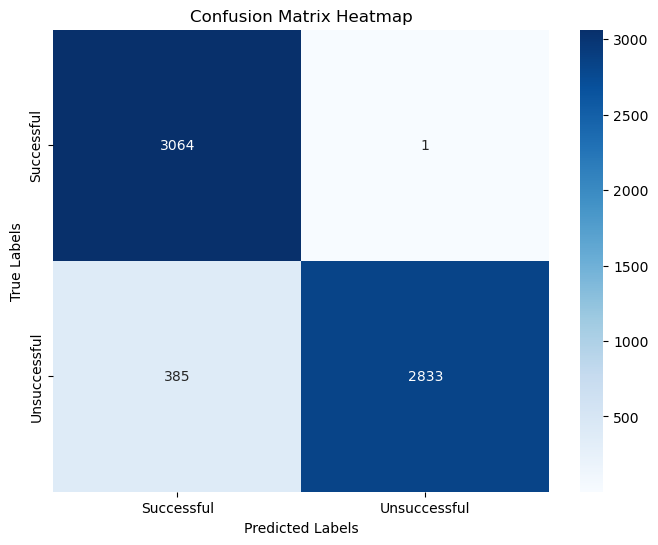

In [49]:
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test, pos_label='successful')
recall = recall_score(y_pred, y_test, pos_label='successful')
f1 = f1_score(y_pred, y_test, pos_label='successful')
conf_matrix = confusion_matrix(y_pred, y_test, labels=['successful', 'unsuccessful'])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

labels = np.array([['True Successful', 'False Unsuccessful'],
                   ['False Successful', 'True Unsuccessful']])

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Successful', 'Unsuccessful'], yticklabels=['Successful', 'Unsuccessful'])

# Add labels and a title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')

# Display the heatmap
plt.show()

### SVM

In [44]:
clf = svm.SVC()
y_pred = clf.fit(X_train, y_train).predict(X_test)

In [45]:
accuracy = clf.score(X_test, y_test)
accuracy

0.9385643800732134

### Gradient Boosting

In [50]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.5705872990609582

### Logistic Regression

In [51]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

/Users/xuyou/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5742479707146267

### Newral Network (MLP)

In [52]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5489415884131784